# Part IV: Modelling

## Basic settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import pickle
import sys
import warnings
from datetime import datetime, timedelta

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

# Set random seed for reproducibility
np.random.seed(2025)

/home/banhmuy/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

In [4]:
from utils.plots import plot_forecast_single
from utils.utils import flatten_prophet_predictions, weighted_absolute_percentage_error

In [5]:
DATA_DIR = "../data"
SALES_DATA_PATH = os.path.join(DATA_DIR, "feature_engineered_data_55_features.feather")

## Load data

In [6]:
df_features = pd.read_feather(SALES_DATA_PATH)

In [7]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193325 entries, 7752 to 200845
Data columns (total 55 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   193325 non-null  datetime64[ns]
 1   province               193325 non-null  object        
 2   store_id               193325 non-null  int64         
 3   store_name             193325 non-null  object        
 4   category               193325 non-null  object        
 5   item_id                193325 non-null  int64         
 6   item_name              193325 non-null  object        
 7   sales                  193325 non-null  float64       
 8   is_test                193325 non-null  bool          
 9   temperature            193325 non-null  float64       
 10  humidity               193325 non-null  float64       
 11  year                   193325 non-null  int32         
 12  month                  193325 non-null  int32 

## Base line model

In [8]:
# Keep original df_features with dates for Prophet
train_data = df_features[~df_features["is_test"]]
test_data = df_features[df_features["is_test"]]

# Create a df_featuresset specifically for Prophet (simpler format)
prophet_data = (
    df_features.groupby(["date", "store_item"])
    .agg(
        {
            "sales": "sum",
            "is_weekend": "first",
            "is_holiday": "first",
            "temperature": "first",
            "humidity": "first",
        }
    )
    .reset_index()
)

prophet_data

,date,store_item,sales,is_weekend,is_holiday,temperature,humidity
0,2016-01-29,Ba Dinh Supermarket_Baby Food,19.0,0,0,16.5,74.3
1,2016-01-29,Ba Dinh Supermarket_Baby Wipes,19.0,0,0,16.5,74.3
2,2016-01-29,Ba Dinh Supermarket_Cheese,12.0,0,0,16.5,74.3
3,2016-01-29,Ba Dinh Supermarket_Chips,35.0,0,0,16.5,74.3
4,2016-01-29,Ba Dinh Supermarket_Chocolate,20.0,0,0,16.5,74.3
...,...,...,...,...,...,...,...
193320,2017-12-31,Tay Ho Store_Toothpaste,65.0,1,0,15.3,70.7
193321,2017-12-31,Tay Ho Store_Trash Bags,30.0,1,0,15.3,70.7
193322,2017-12-31,Tay Ho Store_Vitamins,25.0,1,0,15.3,70.7
193323,2017-12-31,Tay Ho Store_Water,100.0,1,0,15.3,70.7


In [9]:
def build_prophet_model(prophet_data, train_data, test_data):
    """
    Build Prophet models for all store-item combinations in the data.
    """

    print("Building Prophet models for all store-item combinations...")

    # Get all unique store-item keys
    unique_combinations = prophet_data["store_item"].unique()

    # Prepare date range for test set
    min_test_date = test_data["date"].min()
    max_test_date = test_data["date"].max()

    # Storage for output
    prophet_predictions = {}
    prophet_models = {}
    prophet_metrics = pd.DataFrame(columns=["store_item", "mae", "rmse", "wape"])
    all_actual, all_predicted = [], []

    for combo in unique_combinations:
        print(f"Modeling for: {combo}")

        combo_data = prophet_data[prophet_data["store_item"] == combo].copy()

        # Prophet requires columns 'ds' and 'y'
        combo_data = combo_data.rename(columns={"date": "ds", "sales": "y"})

        # Handle missing regressors if any
        for reg in ["is_weekend", "is_holiday", "temperature"]:
            if reg not in combo_data.columns:
                combo_data[reg] = 0  # default fill

        # Split into train/test
        combo_train = combo_data[combo_data["ds"] < min_test_date]
        combo_test = combo_data[
            (combo_data["ds"] >= min_test_date) & (combo_data["ds"] <= max_test_date)
        ]

        # Skip if not enough data
        if combo_train.empty or combo_test.empty:
            print(f"Skipping {combo} due to insufficient data.")
            continue

        # Initialize and fit the Prophet model
        model = Prophet(
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True,
            seasonality_mode="multiplicative",
        )

        # Add regressors
        for reg in ["is_weekend", "is_holiday", "temperature"]:
            model.add_regressor(reg)

        try:
            model.fit(combo_train)
        except Exception as e:
            print(f"Failed to train Prophet for {combo}: {e}")
            continue

        # Create future dataframe
        future = combo_test[["ds", "is_weekend", "is_holiday", "temperature"]]

        # Forecast
        forecast = model.predict(future)

        # Merge actuals
        forecast = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].merge(
            combo_test[["ds", "y"]], on="ds"
        )

        # Save results
        prophet_predictions[combo] = forecast
        prophet_models[combo] = model

        # Evaluate
        mae = mean_absolute_error(forecast["y"], forecast["yhat"])
        rmse = np.sqrt(mean_squared_error(forecast["y"], forecast["yhat"]))
        wape = weighted_absolute_percentage_error(forecast["y"], forecast["yhat"])

        prophet_metrics.loc[len(prophet_metrics)] = [combo, mae, rmse, wape]

        # Track for overall metrics
        all_actual.extend(forecast["y"])
        all_predicted.extend(forecast["yhat"])

    # Overall metrics
    avg_mae = np.mean(prophet_metrics["mae"])
    avg_rmse = np.mean(prophet_metrics["rmse"])
    avg_wape = weighted_absolute_percentage_error(
        np.array(all_actual), np.array(all_predicted)
    )

    return prophet_models, prophet_predictions, (avg_mae, avg_rmse, avg_wape)

In [10]:
prophet_models, prophet_predictions, (avg_mae, avg_rmse, avg_wape) = (
    build_prophet_model(prophet_data, train_data, test_data)
)

Building Prophet models for all store-item combinations...
Modeling for: Ba Dinh Supermarket_Baby Food


21:45:33 - cmdstanpy - INFO - Chain [1] start processing
21:45:33 - cmdstanpy - INFO - Chain [1] done processing
21:45:33 - cmdstanpy - INFO - Chain [1] start processing
21:45:33 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Baby Wipes
Modeling for: Ba Dinh Supermarket_Cheese


21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] done processing
21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Chips
Modeling for: Ba Dinh Supermarket_Chocolate


21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] done processing
21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Coffee
Modeling for: Ba Dinh Supermarket_Cold & Flu Medicine


21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing
21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Cookies


21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Cooking Oil
Modeling for: Ba Dinh Supermarket_Diapers


21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing
21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Dishwashing Liquid


21:45:36 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_First Aid Kit
Modeling for: Ba Dinh Supermarket_Frozen Vegetables


21:45:36 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing
21:45:36 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Ice Cream


21:45:36 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Juice


21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:37 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Laundry Detergent
Modeling for: Ba Dinh Supermarket_Milk


21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:37 - cmdstanpy - INFO - Chain [1] done processing
21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:37 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Pain Relievers


21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:37 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Paper Towels
Modeling for: Ba Dinh Supermarket_Rice


21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:37 - cmdstanpy - INFO - Chain [1] done processing
21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Soap


21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Soda
Modeling for: Ba Dinh Supermarket_Sugar


21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing
21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Tea
Modeling for: Ba Dinh Supermarket_Toilet Paper


21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing
21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Trash Bags
Modeling for: Ba Dinh Supermarket_Vitamins


21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing
21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ba Dinh Supermarket_Yogurt
Modeling for: Ben Thanh Store_All-Purpose Cleaner


21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing
21:45:40 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Baby Food


21:45:40 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Baby Wipes


21:45:40 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Bread
Modeling for: Ben Thanh Store_Cheese


21:45:40 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing
21:45:40 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Chips
Modeling for: Ben Thanh Store_Chocolate


21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Coffee
Modeling for: Ben Thanh Store_Cookies


21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Cooking Oil
Modeling for: Ben Thanh Store_Diapers


21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:42 - cmdstanpy - INFO - Chain [1] done processing
21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:42 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Dishwashing Liquid


21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:42 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Frozen Vegetables


21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:42 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Ice Cream
Modeling for: Ben Thanh Store_Juice


21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing
21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Pain Relievers
Modeling for: Ben Thanh Store_Shampoo


21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing
21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Soap


21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Soda
Modeling for: Ben Thanh Store_Sugar


21:45:44 - cmdstanpy - INFO - Chain [1] start processing
21:45:44 - cmdstanpy - INFO - Chain [1] done processing
21:45:44 - cmdstanpy - INFO - Chain [1] start processing
21:45:44 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Tea
Modeling for: Ben Thanh Store_Toilet Paper


21:45:44 - cmdstanpy - INFO - Chain [1] start processing
21:45:44 - cmdstanpy - INFO - Chain [1] done processing
21:45:44 - cmdstanpy - INFO - Chain [1] start processing
21:45:44 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Trash Bags
Modeling for: Ben Thanh Store_Water


21:45:44 - cmdstanpy - INFO - Chain [1] start processing
21:45:44 - cmdstanpy - INFO - Chain [1] done processing
21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Ben Thanh Store_Yogurt
Modeling for: Binh Thanh Market_All-Purpose Cleaner


21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing
21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Baby Food
Modeling for: Binh Thanh Market_Baby Wipes


21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing
21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Bread


21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Coffee


21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Cold & Flu Medicine
Modeling for: Binh Thanh Market_Cookies


21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing
21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Cooking Oil


21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Diapers
Modeling for: Binh Thanh Market_Dishwashing Liquid


21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing
21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_First Aid Kit
Modeling for: Binh Thanh Market_Ice Cream


21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing
21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Juice
Modeling for: Binh Thanh Market_Milk


21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing
21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Noodles
Modeling for: Binh Thanh Market_Pain Relievers


21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing
21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Paper Towels
Modeling for: Binh Thanh Market_Rice


21:45:49 - cmdstanpy - INFO - Chain [1] start processing
21:45:49 - cmdstanpy - INFO - Chain [1] done processing
21:45:49 - cmdstanpy - INFO - Chain [1] start processing
21:45:49 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Shampoo


21:45:49 - cmdstanpy - INFO - Chain [1] start processing
21:45:49 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Soap
Modeling for: Binh Thanh Market_Soda


21:45:52 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1] done processing
21:45:52 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Sugar


21:45:52 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Toilet Paper
Modeling for: Binh Thanh Market_Trash Bags


21:45:52 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1] done processing
21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:53 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Vitamins
Modeling for: Binh Thanh Market_Water


21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:53 - cmdstanpy - INFO - Chain [1] done processing
21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:53 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Binh Thanh Market_Yogurt
Modeling for: District 1 Market_Baby Food


21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:53 - cmdstanpy - INFO - Chain [1] done processing
21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:53 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Bread
Modeling for: District 1 Market_Cheese


21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing
21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Chips
Modeling for: District 1 Market_Chocolate


21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing
21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Coffee


21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Cold & Flu Medicine


21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Cookies


21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Cooking Oil


21:45:56 - cmdstanpy - INFO - Chain [1] start processing


Modeling for: District 1 Market_Diapers


21:45:56 - cmdstanpy - INFO - Chain [1] done processing
21:45:56 - cmdstanpy - INFO - Chain [1] start processing
21:45:56 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Dishwashing Liquid


21:45:56 - cmdstanpy - INFO - Chain [1] start processing
21:45:56 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_First Aid Kit


21:45:56 - cmdstanpy - INFO - Chain [1] start processing


Modeling for: District 1 Market_Flour


21:45:56 - cmdstanpy - INFO - Chain [1] done processing
21:45:57 - cmdstanpy - INFO - Chain [1] start processing
21:45:57 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Frozen Vegetables
Modeling for: District 1 Market_Ice Cream


21:45:57 - cmdstanpy - INFO - Chain [1] start processing
21:45:57 - cmdstanpy - INFO - Chain [1] done processing
21:45:57 - cmdstanpy - INFO - Chain [1] start processing
21:45:57 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Juice
Modeling for: District 1 Market_Laundry Detergent


21:45:57 - cmdstanpy - INFO - Chain [1] start processing
21:45:57 - cmdstanpy - INFO - Chain [1] done processing
21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Milk


21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Noodles


21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Pain Relievers
Modeling for: District 1 Market_Rice


21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing
21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Shampoo
Modeling for: District 1 Market_Soap


21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Sugar
Modeling for: District 1 Market_Tea


21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Toilet Paper
Modeling for: District 1 Market_Toothpaste


21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing
21:46:00 - cmdstanpy - INFO - Chain [1] start processing
21:46:00 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: District 1 Market_Yogurt
Modeling for: Dong Da Mall_All-Purpose Cleaner


21:46:00 - cmdstanpy - INFO - Chain [1] start processing
21:46:00 - cmdstanpy - INFO - Chain [1] done processing
21:46:00 - cmdstanpy - INFO - Chain [1] start processing
21:46:00 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Baby Food
Modeling for: Dong Da Mall_Bread


21:46:00 - cmdstanpy - INFO - Chain [1] start processing
21:46:00 - cmdstanpy - INFO - Chain [1] done processing
21:46:00 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Cheese
Modeling for: Dong Da Mall_Chips


21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing
21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Chocolate
Modeling for: Dong Da Mall_Cold & Flu Medicine


21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing
21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Diapers


21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Dishwashing Liquid
Modeling for: Dong Da Mall_First Aid Kit


21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing
21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Flour
Modeling for: Dong Da Mall_Frozen Vegetables


21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing
21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Ice Cream
Modeling for: Dong Da Mall_Juice


21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing
21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Laundry Detergent


21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Noodles


21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Pain Relievers
Modeling for: Dong Da Mall_Paper Towels


21:46:04 - cmdstanpy - INFO - Chain [1] start processing
21:46:04 - cmdstanpy - INFO - Chain [1] done processing
21:46:04 - cmdstanpy - INFO - Chain [1] start processing
21:46:04 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Rice


21:46:04 - cmdstanpy - INFO - Chain [1] start processing
21:46:04 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Shampoo
Modeling for: Dong Da Mall_Soap


21:46:04 - cmdstanpy - INFO - Chain [1] start processing
21:46:04 - cmdstanpy - INFO - Chain [1] done processing
21:46:05 - cmdstanpy - INFO - Chain [1] start processing
21:46:05 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Soda


21:46:05 - cmdstanpy - INFO - Chain [1] start processing
21:46:05 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Sugar
Modeling for: Dong Da Mall_Tea


21:46:05 - cmdstanpy - INFO - Chain [1] start processing
21:46:05 - cmdstanpy - INFO - Chain [1] done processing
21:46:05 - cmdstanpy - INFO - Chain [1] start processing
21:46:05 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Toothpaste
Modeling for: Dong Da Mall_Trash Bags


21:46:05 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing
21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Vitamins


21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Dong Da Mall_Water
Modeling for: Dong Da Mall_Yogurt


21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing
21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_All-Purpose Cleaner
Modeling for: Hoan Kiem Market_Baby Food


21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing
21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Bread
Modeling for: Hoan Kiem Market_Cheese


21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing
21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Chips


21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Cold & Flu Medicine
Modeling for: Hoan Kiem Market_Cookies


21:46:08 - cmdstanpy - INFO - Chain [1] start processing
21:46:08 - cmdstanpy - INFO - Chain [1] done processing
21:46:08 - cmdstanpy - INFO - Chain [1] start processing
21:46:08 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Cooking Oil
Modeling for: Hoan Kiem Market_Diapers


21:46:08 - cmdstanpy - INFO - Chain [1] start processing
21:46:08 - cmdstanpy - INFO - Chain [1] done processing
21:46:08 - cmdstanpy - INFO - Chain [1] start processing
21:46:08 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Dishwashing Liquid
Modeling for: Hoan Kiem Market_First Aid Kit


21:46:09 - cmdstanpy - INFO - Chain [1] start processing
21:46:09 - cmdstanpy - INFO - Chain [1] done processing
21:46:09 - cmdstanpy - INFO - Chain [1] start processing
21:46:09 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Flour
Modeling for: Hoan Kiem Market_Frozen Vegetables


21:46:09 - cmdstanpy - INFO - Chain [1] start processing
21:46:09 - cmdstanpy - INFO - Chain [1] done processing
21:46:09 - cmdstanpy - INFO - Chain [1] start processing
21:46:09 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Ice Cream
Modeling for: Hoan Kiem Market_Juice


21:46:09 - cmdstanpy - INFO - Chain [1] start processing
21:46:09 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Laundry Detergent


21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Milk
Modeling for: Hoan Kiem Market_Noodles


21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Pain Relievers
Modeling for: Hoan Kiem Market_Paper Towels


21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:11 - cmdstanpy - INFO - Chain [1] done processing
21:46:11 - cmdstanpy - INFO - Chain [1] start processing
21:46:11 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Rice
Modeling for: Hoan Kiem Market_Shampoo


21:46:11 - cmdstanpy - INFO - Chain [1] start processing
21:46:11 - cmdstanpy - INFO - Chain [1] done processing
21:46:11 - cmdstanpy - INFO - Chain [1] start processing
21:46:11 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Soap
Modeling for: Hoan Kiem Market_Sugar


21:46:12 - cmdstanpy - INFO - Chain [1] start processing
21:46:12 - cmdstanpy - INFO - Chain [1] done processing
21:46:12 - cmdstanpy - INFO - Chain [1] start processing
21:46:12 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Tea
Modeling for: Hoan Kiem Market_Toilet Paper


21:46:12 - cmdstanpy - INFO - Chain [1] start processing
21:46:12 - cmdstanpy - INFO - Chain [1] done processing
21:46:12 - cmdstanpy - INFO - Chain [1] start processing
21:46:12 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Toothpaste


21:46:13 - cmdstanpy - INFO - Chain [1] start processing
21:46:13 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Trash Bags
Modeling for: Hoan Kiem Market_Water


21:46:13 - cmdstanpy - INFO - Chain [1] start processing
21:46:13 - cmdstanpy - INFO - Chain [1] done processing
21:46:13 - cmdstanpy - INFO - Chain [1] start processing
21:46:13 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Hoan Kiem Market_Yogurt
Modeling for: Long Bien Shop_All-Purpose Cleaner


21:46:13 - cmdstanpy - INFO - Chain [1] start processing
21:46:13 - cmdstanpy - INFO - Chain [1] done processing
21:46:14 - cmdstanpy - INFO - Chain [1] start processing
21:46:14 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Bread
Modeling for: Long Bien Shop_Cheese


21:46:14 - cmdstanpy - INFO - Chain [1] start processing
21:46:14 - cmdstanpy - INFO - Chain [1] done processing
21:46:14 - cmdstanpy - INFO - Chain [1] start processing
21:46:14 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Chips


21:46:14 - cmdstanpy - INFO - Chain [1] start processing
21:46:14 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Chocolate


21:46:14 - cmdstanpy - INFO - Chain [1] start processing
21:46:14 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Cold & Flu Medicine


21:46:15 - cmdstanpy - INFO - Chain [1] start processing
21:46:15 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Cooking Oil
Modeling for: Long Bien Shop_Diapers


21:46:15 - cmdstanpy - INFO - Chain [1] start processing
21:46:15 - cmdstanpy - INFO - Chain [1] done processing
21:46:15 - cmdstanpy - INFO - Chain [1] start processing
21:46:15 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Dishwashing Liquid


21:46:15 - cmdstanpy - INFO - Chain [1] start processing
21:46:15 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Flour
Modeling for: Long Bien Shop_Frozen Vegetables


21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:16 - cmdstanpy - INFO - Chain [1] done processing
21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:16 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Ice Cream
Modeling for: Long Bien Shop_Juice


21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:16 - cmdstanpy - INFO - Chain [1] done processing
21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:16 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Milk
Modeling for: Long Bien Shop_Noodles


21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:16 - cmdstanpy - INFO - Chain [1] done processing
21:46:17 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Pain Relievers
Modeling for: Long Bien Shop_Paper Towels


21:46:17 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing
21:46:17 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Rice
Modeling for: Long Bien Shop_Shampoo


21:46:17 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing
21:46:17 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Soap
Modeling for: Long Bien Shop_Soda


21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:18 - cmdstanpy - INFO - Chain [1] done processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:18 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Tea


21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:18 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Toilet Paper
Modeling for: Long Bien Shop_Toothpaste


21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:18 - cmdstanpy - INFO - Chain [1] done processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:19 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Trash Bags
Modeling for: Long Bien Shop_Vitamins


21:46:19 - cmdstanpy - INFO - Chain [1] start processing
21:46:19 - cmdstanpy - INFO - Chain [1] done processing
21:46:19 - cmdstanpy - INFO - Chain [1] start processing
21:46:19 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Long Bien Shop_Yogurt
Modeling for: Phu Nhuan Shop_Baby Wipes


21:46:19 - cmdstanpy - INFO - Chain [1] start processing
21:46:19 - cmdstanpy - INFO - Chain [1] done processing
21:46:19 - cmdstanpy - INFO - Chain [1] start processing
21:46:19 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Cheese
Modeling for: Phu Nhuan Shop_Chocolate


21:46:20 - cmdstanpy - INFO - Chain [1] start processing
21:46:20 - cmdstanpy - INFO - Chain [1] done processing
21:46:20 - cmdstanpy - INFO - Chain [1] start processing
21:46:20 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Coffee


21:46:20 - cmdstanpy - INFO - Chain [1] start processing
21:46:20 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Cold & Flu Medicine
Modeling for: Phu Nhuan Shop_Cookies


21:46:20 - cmdstanpy - INFO - Chain [1] start processing
21:46:20 - cmdstanpy - INFO - Chain [1] done processing
21:46:20 - cmdstanpy - INFO - Chain [1] start processing
21:46:21 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Cooking Oil


21:46:21 - cmdstanpy - INFO - Chain [1] start processing
21:46:21 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Dishwashing Liquid
Modeling for: Phu Nhuan Shop_Frozen Vegetables


21:46:21 - cmdstanpy - INFO - Chain [1] start processing
21:46:21 - cmdstanpy - INFO - Chain [1] done processing
21:46:21 - cmdstanpy - INFO - Chain [1] start processing
21:46:21 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Ice Cream


21:46:21 - cmdstanpy - INFO - Chain [1] start processing
21:46:21 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Juice
Modeling for: Phu Nhuan Shop_Laundry Detergent


21:46:21 - cmdstanpy - INFO - Chain [1] start processing
21:46:22 - cmdstanpy - INFO - Chain [1] done processing
21:46:22 - cmdstanpy - INFO - Chain [1] start processing
21:46:22 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Milk
Modeling for: Phu Nhuan Shop_Noodles


21:46:22 - cmdstanpy - INFO - Chain [1] start processing
21:46:22 - cmdstanpy - INFO - Chain [1] done processing
21:46:22 - cmdstanpy - INFO - Chain [1] start processing
21:46:22 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Pain Relievers
Modeling for: Phu Nhuan Shop_Rice


21:46:22 - cmdstanpy - INFO - Chain [1] start processing
21:46:22 - cmdstanpy - INFO - Chain [1] done processing
21:46:23 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Shampoo
Modeling for: Phu Nhuan Shop_Soap


21:46:23 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing
21:46:23 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Soda
Modeling for: Phu Nhuan Shop_Sugar


21:46:23 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing
21:46:23 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Tea
Modeling for: Phu Nhuan Shop_Toothpaste


21:46:24 - cmdstanpy - INFO - Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1] done processing
21:46:24 - cmdstanpy - INFO - Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Trash Bags
Modeling for: Phu Nhuan Shop_Vitamins


21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing
21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Water


21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Phu Nhuan Shop_Yogurt


21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Baby Food


21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Baby Wipes


21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Bread
Modeling for: Saigon Supermarket_Cheese


21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing
21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Cold & Flu Medicine


21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Cookies


21:46:29 - cmdstanpy - INFO - Chain [1] start processing


Modeling for: Saigon Supermarket_Diapers


21:46:29 - cmdstanpy - INFO - Chain [1] done processing
21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Dishwashing Liquid


21:46:30 - cmdstanpy - INFO - Chain [1] start processing


Modeling for: Saigon Supermarket_First Aid Kit


21:46:30 - cmdstanpy - INFO - Chain [1] done processing
21:46:30 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Flour


21:46:30 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Ice Cream


21:46:30 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Juice
Modeling for: Saigon Supermarket_Laundry Detergent


21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing
21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Milk


21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Noodles


21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Paper Towels
Modeling for: Saigon Supermarket_Rice


21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing
21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Shampoo
Modeling for: Saigon Supermarket_Soap


21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing
21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Soda
Modeling for: Saigon Supermarket_Sugar


21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing
21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Tea


21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Toilet Paper


21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Toothpaste


21:46:34 - cmdstanpy - INFO - Chain [1] start processing
21:46:34 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Vitamins


21:46:34 - cmdstanpy - INFO - Chain [1] start processing
21:46:34 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Saigon Supermarket_Water
Modeling for: Saigon Supermarket_Yogurt


21:46:34 - cmdstanpy - INFO - Chain [1] start processing
21:46:34 - cmdstanpy - INFO - Chain [1] done processing
21:46:34 - cmdstanpy - INFO - Chain [1] start processing
21:46:34 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Baby Food


21:46:35 - cmdstanpy - INFO - Chain [1] start processing
21:46:35 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Baby Wipes


21:46:35 - cmdstanpy - INFO - Chain [1] start processing
21:46:35 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Bread
Modeling for: Tay Ho Store_Cheese


21:46:35 - cmdstanpy - INFO - Chain [1] start processing
21:46:35 - cmdstanpy - INFO - Chain [1] done processing
21:46:35 - cmdstanpy - INFO - Chain [1] start processing
21:46:35 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Chips
Modeling for: Tay Ho Store_Coffee


21:46:35 - cmdstanpy - INFO - Chain [1] start processing
21:46:35 - cmdstanpy - INFO - Chain [1] done processing
21:46:36 - cmdstanpy - INFO - Chain [1] start processing
21:46:36 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Cold & Flu Medicine
Modeling for: Tay Ho Store_Cookies


21:46:36 - cmdstanpy - INFO - Chain [1] start processing
21:46:36 - cmdstanpy - INFO - Chain [1] done processing
21:46:36 - cmdstanpy - INFO - Chain [1] start processing
21:46:36 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Cooking Oil


21:46:36 - cmdstanpy - INFO - Chain [1] start processing
21:46:36 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Diapers


21:46:36 - cmdstanpy - INFO - Chain [1] start processing
21:46:37 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Dishwashing Liquid


21:46:37 - cmdstanpy - INFO - Chain [1] start processing
21:46:37 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_First Aid Kit


21:46:37 - cmdstanpy - INFO - Chain [1] start processing
21:46:37 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Flour
Modeling for: Tay Ho Store_Ice Cream


21:46:37 - cmdstanpy - INFO - Chain [1] start processing
21:46:37 - cmdstanpy - INFO - Chain [1] done processing
21:46:37 - cmdstanpy - INFO - Chain [1] start processing
21:46:37 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Laundry Detergent
Modeling for: Tay Ho Store_Milk


21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing
21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Noodles
Modeling for: Tay Ho Store_Pain Relievers


21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing
21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Rice


21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Shampoo
Modeling for: Tay Ho Store_Soap


21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing
21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Soda
Modeling for: Tay Ho Store_Sugar


21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing
21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Toothpaste
Modeling for: Tay Ho Store_Trash Bags


21:46:40 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing
21:46:40 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Vitamins
Modeling for: Tay Ho Store_Water


21:46:40 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing
21:46:40 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing


Modeling for: Tay Ho Store_Yogurt


In [11]:
# Accuracy of Prophet Model
print(
    f"Prophet Model Results:\nMAE: {avg_mae:.2f} | RMSE: {avg_rmse:.2f} | WAPE: {avg_wape:.2f}%"
)

Prophet Model Results:
MAE: 8.96 | RMSE: 11.57 | WAPE: 29.04%


In [12]:
# Convert predicted result to pandas dataframe
df_prophet_predictions = flatten_prophet_predictions(prophet_predictions)
display(df_prophet_predictions.head())

,ds,yhat,yhat_lower,yhat_upper,y,store_item
0,2017-10-01,21.506627,13.012656,29.558119,19.0,Ba Dinh Supermarket_Baby Food
1,2017-10-02,17.244530,9.121246,25.363008,13.0,Ba Dinh Supermarket_Baby Food
2,2017-10-03,16.733479,8.231986,24.600604,19.0,Ba Dinh Supermarket_Baby Food
3,2017-10-04,18.747652,10.762040,26.692634,22.0,Ba Dinh Supermarket_Baby Food
4,2017-10-05,17.989220,10.060651,26.235783,12.0,Ba Dinh Supermarket_Baby Food


In [13]:
df_prophet_predictions.groupby("store_item").count().reset_index()

,store_item,ds,yhat,yhat_lower,yhat_upper,y
0,Ba Dinh Supermarket_Baby Food,92,92,92,92,92
1,Ba Dinh Supermarket_Baby Wipes,92,92,92,92,92
2,Ba Dinh Supermarket_Cheese,92,92,92,92,92
3,Ba Dinh Supermarket_Chips,92,92,92,92,92
4,Ba Dinh Supermarket_Chocolate,92,92,92,92,92
...,...,...,...,...,...,...
270,Tay Ho Store_Toothpaste,92,92,92,92,92
271,Tay Ho Store_Trash Bags,92,92,92,92,92
272,Tay Ho Store_Vitamins,92,92,92,92,92
273,Tay Ho Store_Water,92,92,92,92,92


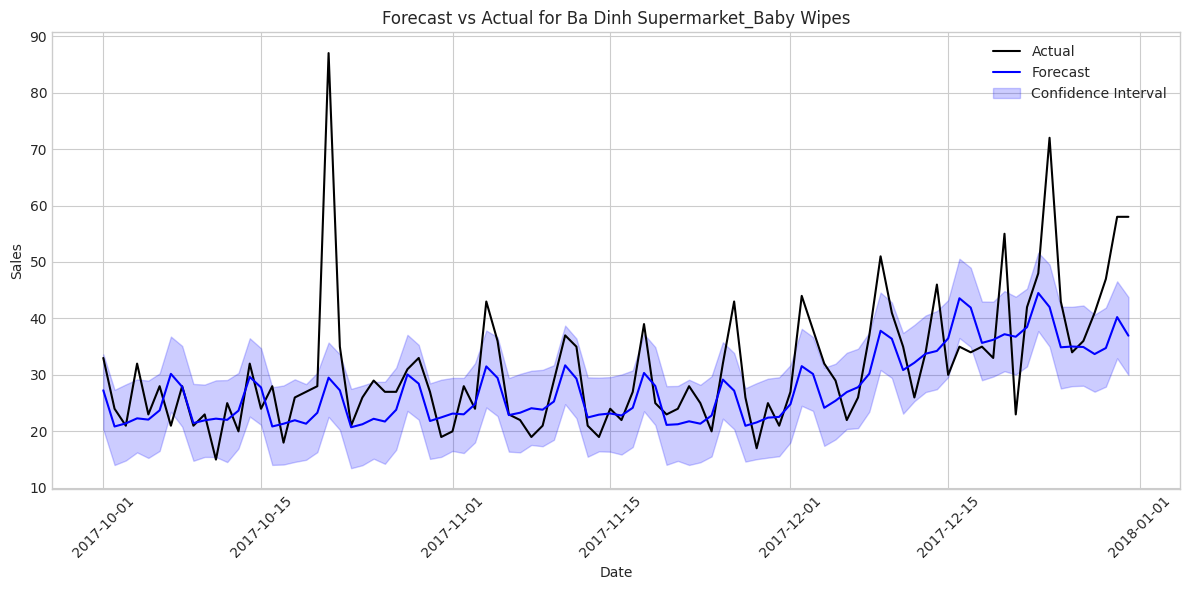

In [14]:
plot_forecast_single(df_prophet_predictions, "Ba Dinh Supermarket_Baby Wipes")

## Build lightgbm model

### Split train and test data

In [15]:
# Drop unnecessary columns for modeling
cols_to_drop = [
    "date",
    "province",
    "store_name",
    "item_name",
    "store_item",
    "is_test",
    "category",
]

# Split features and target, and separate train/test
X_train = df_features[~df_features["is_test"]].drop(cols_to_drop + ["sales"], axis=1)
y_train = df_features[~df_features["is_test"]]["sales"]

X_test = df_features[df_features["is_test"]].drop(cols_to_drop + ["sales"], axis=1)
y_test = df_features[df_features["is_test"]]["sales"]

In [16]:
X_train

,store_id,item_id,temperature,humidity,year,month,day,day_of_week,is_weekend,quarter,...,sales_ewma_7d_a05,sales_ewma_14d_a05,sales_ewma_28d_a05,sales_ewma_7d_a075,sales_ewma_14d_a075,sales_ewma_28d_a075,store_mean_7d,store_sum_7d,item_mean_7d,item_sum_7d
7752,2,30,16.5,74.3,2016,1,29,4,0,1,...,21.583537,21.583537,21.583537,25.413829,25.413829,25.413829,21.911177,613.512944,28.875000,231.000000
7753,2,31,16.5,74.3,2016,1,29,4,0,1,...,32.386439,32.386439,32.386439,35.632680,35.632680,35.632680,21.911177,613.512944,39.833333,239.000000
7734,2,8,16.5,74.3,2016,1,29,4,0,1,...,11.023524,11.023524,11.023524,9.559820,9.559820,9.559820,21.911177,613.512944,18.666667,168.000000
7742,2,17,16.5,74.3,2016,1,29,4,0,1,...,51.820048,51.820048,51.820048,64.582391,64.582391,64.582391,21.911177,613.512944,49.644706,347.512944
7744,2,19,16.5,74.3,2016,1,29,4,0,1,...,35.006622,35.006622,35.006622,34.640615,34.640615,34.640615,21.911177,613.512944,43.000000,258.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175554,4,22,28.4,77.6,2017,9,30,5,1,3,...,26.302621,26.302621,26.302621,26.906396,26.906396,26.906396,27.608067,773.025887,36.714286,257.000000
175556,4,26,28.4,77.6,2017,9,30,5,1,3,...,15.989442,15.989442,15.989442,15.849293,15.849293,15.849293,27.608067,773.025887,18.125000,145.000000
175562,4,33,28.4,77.6,2017,9,30,5,1,3,...,13.924204,13.924204,13.924204,13.578833,13.578833,13.578833,27.608067,773.025887,14.857143,104.000000
175548,4,14,28.4,77.6,2017,9,30,5,1,3,...,51.558112,51.558112,51.558112,49.825068,49.825068,49.825068,27.608067,773.025887,40.296809,282.077662


### Build a lightgbm model

In [17]:
def create_lightgbm_model(X_train, y_train, X_test, y_test):
    """
    Create a LightGBM model using engineered features
    """
    print("\nCreating base lightgbm model...")

    # Use a time series split for validation within the training set
    # This ensures we're always validating on future data
    tscv = TimeSeriesSplit(n_splits=5)

    # Basic LightGBM parameters
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "num_leaves": 31,
        "learning_rate": 0.05,
        "feature_fraction": 0.9,
        "n_estimators": 100,
        "verbose": -1,
    }

    # Train the model with cross-validation on training data only
    cv_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model
        model = lgbm.LGBMRegressor(**params)
        model.fit(
            X_train_cv,
            y_train_cv,
            eval_set=[(X_val_cv, y_val_cv)],
            # early_stopping_rounds=50,
            # verbose=False
        )

        # Make predictions
        preds = model.predict(X_val_cv)

        # Calculate metrics
        mae = mean_absolute_error(y_val_cv, preds)
        rmse = np.sqrt(mean_squared_error(y_val_cv, preds))
        wape = weighted_absolute_percentage_error(y_val_cv, preds)

        cv_scores.append((mae, rmse, wape))

    # Print average scores from cross-validation
    mae_avg, rmse_avg, wape_avg = np.mean(cv_scores, axis=0)
    print(
        f"Baseline Model CV - MAE: {mae_avg:.2f}, RMSE: {rmse_avg:.2f}, WAPE: {wape_avg:.2f}%"
    )

    # Train a final model on all training data
    final_model = lgbm.LGBMRegressor(**params)
    final_model.fit(X_train, y_train)

    # Evaluate on the test set (last 3 months of 2017)
    test_preds = final_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_wape = weighted_absolute_percentage_error(y_test, test_preds)

    print(
        f"Baseline Model Test - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, WAPE: {test_wape:.2f}%"
    )

    return final_model, (test_mae, test_rmse, test_wape)

In [18]:
# Create basic lgihtgbm model
lightgbm_model, lightgbm_metrics = create_lightgbm_model(
    X_train, y_train, X_test, y_test
)


Creating base lightgbm model...
Baseline Model CV - MAE: 7.04, RMSE: 11.18, WAPE: 25.71%
Baseline Model Test - MAE: 7.73, RMSE: 11.93, WAPE: 25.05%


### (Optional) Fine tunning using Optuna

In [19]:
def optimize_lightgbm(X_train, y_train, X_test, y_test):
    """
    Optimize LightGBM model using Optuna
    """

    print("\nOptimizing LightGBM model with Optuna...")

    def objective(trial):
        """Optuna objective function for LightGBM optimization"""
        params = {
            "objective": "regression",
            "metric": "rmse",
            "boosting_type": "gbdt",
            "num_leaves": trial.suggest_int("num_leaves", 15, 50),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
            "n_estimators": 1000,
            "verbose": -1,
        }

        # Train with early stopping
        model = lgbm.LGBMRegressor(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            callbacks=[lgbm.early_stopping(stopping_rounds=50)],
            # verbose=False,
        )

        # Predict and calculate RMSE
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        return rmse

    # Create and run study
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)  # In practice, use more trials

    # Get best parameters
    best_params = study.best_params
    best_params.update(
        {
            "objective": "regression",
            "metric": "rmse",
            "boosting_type": "gbdt",
            "verbose": -1,
        }
    )

    print("Best LightGBM parameters found:")
    for key, value in best_params.items():
        print(f"    {key}: {value}")

    # Train final model with best parameters
    final_model = lgbm.LGBMRegressor(**best_params)
    final_model.fit(X_train, y_train)

    # Make predictions
    test_preds = final_model.predict(X_test)

    # Calculate metrics
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_wape = weighted_absolute_percentage_error(y_test, test_preds)

    print(
        f"Optimized LightGBM Test Metrics - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, WAPE: {test_wape:.2f}%"
    )

    return final_model, test_preds, (test_mae, test_rmse, test_wape)

In [20]:
optimized_model, best_params, optimized_metrics = optimize_lightgbm(
    X_train, y_train, X_test, y_test
)

[I 2025-12-12 21:47:09,473] A new study created in memory with name: no-name-5aabfe39-9e4c-4284-9c87-ab71bb3d2604



Optimizing LightGBM model with Optuna...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[580]	valid_0's rmse: 11.8507


[I 2025-12-12 21:47:31,537] Trial 0 finished with value: 11.850685917017888 and parameters: {'num_leaves': 27, 'learning_rate': 0.029952448891322182, 'feature_fraction': 0.8013934677591735, 'bagging_fraction': 0.9041525661309618, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 11.850685917017888.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[892]	valid_0's rmse: 11.8342


[I 2025-12-12 21:48:12,510] Trial 1 finished with value: 11.834220766568773 and parameters: {'num_leaves': 36, 'learning_rate': 0.015348149256399914, 'feature_fraction': 0.9619786306724984, 'bagging_fraction': 0.9682500811900017, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 1 with value: 11.834220766568773.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's rmse: 11.913


[I 2025-12-12 21:48:21,682] Trial 2 finished with value: 11.913031701923108 and parameters: {'num_leaves': 50, 'learning_rate': 0.09195002191286933, 'feature_fraction': 0.7025382368843581, 'bagging_fraction': 0.7142433823165617, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 1 with value: 11.834220766568773.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[839]	valid_0's rmse: 11.8454


[I 2025-12-12 21:48:43,349] Trial 3 finished with value: 11.845369771312555 and parameters: {'num_leaves': 15, 'learning_rate': 0.02853478257731809, 'feature_fraction': 0.9310024997599389, 'bagging_fraction': 0.7298092926792583, 'bagging_freq': 10, 'min_child_samples': 26}. Best is trial 1 with value: 11.834220766568773.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[599]	valid_0's rmse: 11.8264


[I 2025-12-12 21:49:06,994] Trial 4 finished with value: 11.826365986129886 and parameters: {'num_leaves': 19, 'learning_rate': 0.0381426637293487, 'feature_fraction': 0.8215166691499638, 'bagging_fraction': 0.7112382376879722, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 4 with value: 11.826365986129886.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[979]	valid_0's rmse: 11.8622


[I 2025-12-12 21:49:37,749] Trial 5 finished with value: 11.862203434878179 and parameters: {'num_leaves': 19, 'learning_rate': 0.01781972821113451, 'feature_fraction': 0.9947625936993043, 'bagging_fraction': 0.9677657006624598, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 4 with value: 11.826365986129886.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 11.8873


[I 2025-12-12 21:50:19,827] Trial 6 finished with value: 11.88728741477579 and parameters: {'num_leaves': 26, 'learning_rate': 0.010285782405265394, 'feature_fraction': 0.7507346907686073, 'bagging_fraction': 0.9875590412779781, 'bagging_freq': 8, 'min_child_samples': 9}. Best is trial 4 with value: 11.826365986129886.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[255]	valid_0's rmse: 11.8725


[I 2025-12-12 21:50:34,034] Trial 7 finished with value: 11.872549429550801 and parameters: {'num_leaves': 34, 'learning_rate': 0.0873105983660565, 'feature_fraction': 0.7748841106487673, 'bagging_fraction': 0.8970449651053413, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 4 with value: 11.826365986129886.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[419]	valid_0's rmse: 11.8409


[I 2025-12-12 21:50:49,859] Trial 8 finished with value: 11.840900923477381 and parameters: {'num_leaves': 38, 'learning_rate': 0.037692054350777236, 'feature_fraction': 0.954564635993856, 'bagging_fraction': 0.7419156832275633, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 4 with value: 11.826365986129886.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[243]	valid_0's rmse: 11.9019


[I 2025-12-12 21:51:00,149] Trial 9 finished with value: 11.901941936155252 and parameters: {'num_leaves': 32, 'learning_rate': 0.05468308795172053, 'feature_fraction': 0.7951876398768716, 'bagging_fraction': 0.7740443866682187, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 4 with value: 11.826365986129886.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[340]	valid_0's rmse: 11.8267


[I 2025-12-12 21:51:13,997] Trial 10 finished with value: 11.826674755711636 and parameters: {'num_leaves': 22, 'learning_rate': 0.06645166997966907, 'feature_fraction': 0.8789141392151261, 'bagging_fraction': 0.8216613999112762, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 4 with value: 11.826365986129886.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[254]	valid_0's rmse: 11.8568


[I 2025-12-12 21:51:23,150] Trial 11 finished with value: 11.856785858533472 and parameters: {'num_leaves': 21, 'learning_rate': 0.0648989497222207, 'feature_fraction': 0.8739196098590596, 'bagging_fraction': 0.8086368702283385, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 4 with value: 11.826365986129886.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[560]	valid_0's rmse: 11.8117


[I 2025-12-12 21:51:47,817] Trial 12 finished with value: 11.81174890712132 and parameters: {'num_leaves': 23, 'learning_rate': 0.058570256074413254, 'feature_fraction': 0.8668746699321196, 'bagging_fraction': 0.8336721742140957, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 12 with value: 11.81174890712132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[460]	valid_0's rmse: 11.8422


[I 2025-12-12 21:52:04,628] Trial 13 finished with value: 11.842166294650548 and parameters: {'num_leaves': 16, 'learning_rate': 0.0488682342480758, 'feature_fraction': 0.8438471425039178, 'bagging_fraction': 0.8683713102832271, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 12 with value: 11.81174890712132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[251]	valid_0's rmse: 11.8454


[I 2025-12-12 21:52:18,104] Trial 14 finished with value: 11.845381440650712 and parameters: {'num_leaves': 27, 'learning_rate': 0.07428182455355868, 'feature_fraction': 0.8445610040580622, 'bagging_fraction': 0.7702840085597326, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 12 with value: 11.81174890712132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[296]	valid_0's rmse: 11.833


[I 2025-12-12 21:52:33,923] Trial 15 finished with value: 11.832976429065363 and parameters: {'num_leaves': 43, 'learning_rate': 0.045365269287036616, 'feature_fraction': 0.9006246933176144, 'bagging_fraction': 0.8457665107833006, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 12 with value: 11.81174890712132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[328]	valid_0's rmse: 11.8696


[I 2025-12-12 21:52:46,514] Trial 16 finished with value: 11.86963888086651 and parameters: {'num_leaves': 22, 'learning_rate': 0.07556426369044075, 'feature_fraction': 0.8279647520774284, 'bagging_fraction': 0.9187583521045615, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 12 with value: 11.81174890712132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[432]	valid_0's rmse: 11.847


[I 2025-12-12 21:53:11,086] Trial 17 finished with value: 11.847035288786083 and parameters: {'num_leaves': 30, 'learning_rate': 0.03953521002148007, 'feature_fraction': 0.7384467534962601, 'bagging_fraction': 0.7839707121269207, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 12 with value: 11.81174890712132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[351]	valid_0's rmse: 11.8595


[I 2025-12-12 21:53:28,168] Trial 18 finished with value: 11.85949990908274 and parameters: {'num_leaves': 25, 'learning_rate': 0.06155041398126405, 'feature_fraction': 0.904389960338915, 'bagging_fraction': 0.7053967924071586, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 12 with value: 11.81174890712132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[939]	valid_0's rmse: 11.8394


[I 2025-12-12 21:54:06,634] Trial 19 finished with value: 11.839406354661444 and parameters: {'num_leaves': 18, 'learning_rate': 0.02986673928489532, 'feature_fraction': 0.8125101776410828, 'bagging_fraction': 0.8681452151200898, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 12 with value: 11.81174890712132.


Best LightGBM parameters found:
    num_leaves: 23
    learning_rate: 0.058570256074413254
    feature_fraction: 0.8668746699321196
    bagging_fraction: 0.8336721742140957
    bagging_freq: 2
    min_child_samples: 20
    objective: regression
    metric: rmse
    boosting_type: gbdt
    verbose: -1
Optimized LightGBM Test Metrics - MAE: 7.74, RMSE: 11.95, WAPE: 25.08%


## Evaluating model

In [21]:
def evaluate_model(model, X_test, y_test, data):
    """
    Evaluate the model performance on the test set (last 3 months of 2017)
    """
    print("\nEvaluating model performance on test set...")

    # Make predictions on the test set
    test_preds = model.predict(X_test)

    # Calculate metrics
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_wape = weighted_absolute_percentage_error(y_test, test_preds)

    # Print evaluation results
    print(f"Final Model Test Evaluation:")
    print(f"    MAE: {test_mae:.2f}")
    print(f"    RMSE: {test_rmse:.2f}")
    print(f"    WAPE: {test_wape:.2f}%")

    # Analyze errors by time period (month)
    test_results = data[data["is_test"]].copy()
    test_results["prediction"] = test_preds
    test_results["error"] = test_results["sales"] - test_results["prediction"]
    test_results["abs_error"] = np.abs(test_results["error"])
    test_results["month_name"] = test_results["date"].dt.strftime("%B")

    # Summarize errors by month
    monthly_errors = (
        test_results.groupby("month_name")
        .agg({"abs_error": "mean", "error": "mean", "sales": "mean"})
        .reset_index()
    )
    monthly_errors["error_pct"] = (
        100 * monthly_errors["abs_error"] / monthly_errors["sales"]
    )

    print("\nError Analysis by Month:")
    print(
        monthly_errors[["month_name", "abs_error", "error_pct"]].to_string(index=False)
    )

    # Store results for visualization
    # Include month and store information for granular analysis
    test_results["year_month"] = test_results["date"].dt.strftime("%Y-%m")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_preds, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "r--")
    plt.title("Actual vs Predicted Sales (Test Set)")
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")
    plt.tight_layout()
    # plt.savefig('actual_vs_predicted_test.png')

    # Plot error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(test_results["error"], kde=True)
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error")
    plt.tight_layout()
    # plt.savefig('error_distribution.png')

    return test_mae, test_rmse, test_wape, test_preds, y_test, test_results

In [22]:
# Prophet Model Results:
# MAE: 9.03 | RMSE: 11.86 | WAPE: 29.13%


Evaluating model performance on test set...
Final Model Test Evaluation:
    MAE: 7.73
    RMSE: 11.93
    WAPE: 25.05%

Error Analysis by Month:
month_name  abs_error  error_pct
  December   9.270384  25.601927
  November   6.868284  24.583743
   October   7.026320  24.779187


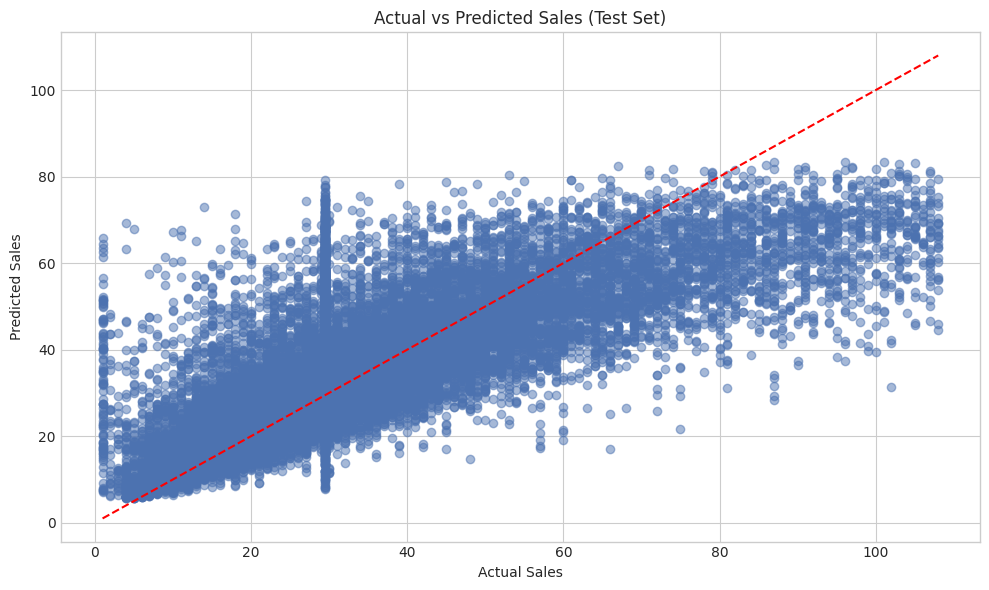

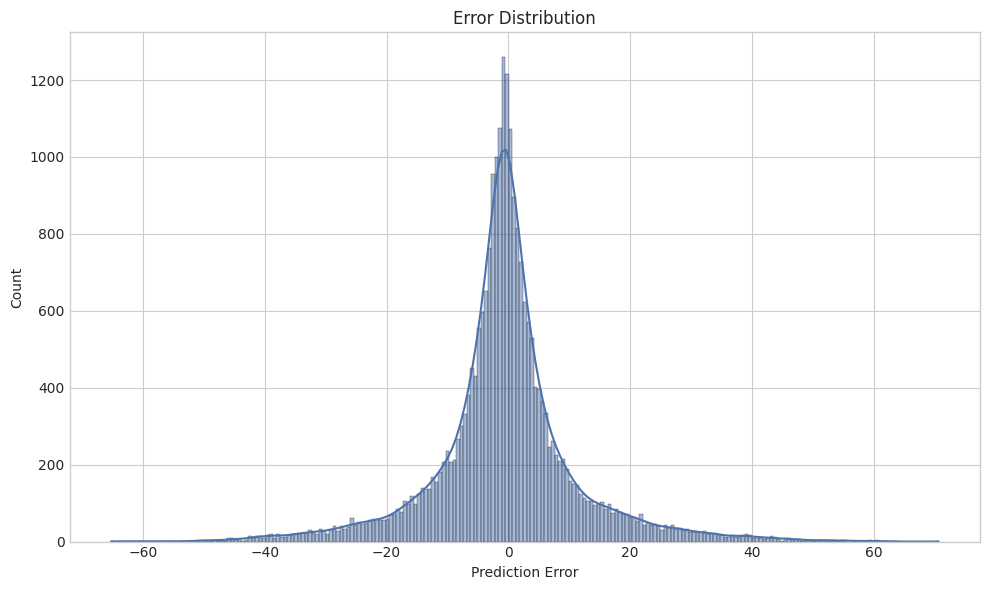

In [23]:
# Evaluate the lightgbm model
test_mae, test_rmse, test_smape, test_preds, y_test_values, test_results = (
    evaluate_model(lightgbm_model, X_test, y_test, df_features)
)

## Save trained models

In [24]:
def save_model(model, X_train, feature_names, output_dir="../models"):
    """
    Save the trained model and related artifacts for API use

    Args:
        model: Trained model (e.g., LightGBM model)
        feature_names: List of feature names
        output_dir: Directory to save model artifacts
    """

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save the model
    model_path = os.path.join(output_dir, "sales_forecast_model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_path}")

    # Create and save feature statistics
    feature_stats = {
        "model_version": "1.0.0",
        "last_trained": pd.Timestamp.now().strftime("%Y-%m-%d"),
        "required_columns": list(feature_names),
        "column_order": list(feature_names),
        "default_values": {},
        "temperature_bins": [-np.inf, 20, 25, 30, np.inf],
        "temperature_labels": ["Cold", "Cool", "Warm", "Hot"],
        "humidity_bins": [-np.inf, 60, 75, np.inf],
        "humidity_labels": ["Low", "Medium", "High"],
    }

    # Add default values for date features
    feature_stats["default_values"] = {
        "year": 2017,
        "month": 11,
        "day": 15,
        "day_of_week": 2,
        "is_weekend": 0,
        "quarter": 4,
        "is_holiday": 0,
    }

    # Save feature stats
    stats_path = os.path.join(output_dir, "feature_stats.json")
    with open(stats_path, "w") as f:
        json.dump(feature_stats, f, indent=4)
    print(f"Feature statistics saved to {stats_path}")

    print(f"All model artifacts saved successfully to {output_dir}/")

    return model_path, stats_path

In [25]:
# Save model
save_model(
    model=optimized_model,
    X_train=X_train,
    feature_names=X_train.columns,
    output_dir='../models'
)

Model saved to ../models/sales_forecast_model.pkl
Feature statistics saved to ../models/feature_stats.json
All model artifacts saved successfully to ../models/


('../models/sales_forecast_model.pkl', '../models/feature_stats.json')